In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed
#   - In Tensoflow2 there is no need to perform
#   - You can directly run " set_random_seed(x) "
# Instead...
import tensorflow # tensorflow.random.set_seed(x)

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

import os
for dirname, _, filenames in os.walk('../input/NASA-bearing-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/NASA-bearing-dataset/merged_dataset_BearingTest_2.csv
../input/NASA-bearing-dataset/sample_1st.csv
../input/NASA-bearing-dataset/merged_dataset_BearingTest_1.csv
../input/NASA-bearing-dataset/sample_2nd.csv
../input/NASA-bearing-dataset/merged_dataset_BearingTest_3.csv
../input/NASA-bearing-dataset/sample_3rd.csv


In [2]:
!pip list | grep tensorflow

tensorflow                     2.4.1
tensorflow-addons              0.12.1
tensorflow-cloud               0.1.13
tensorflow-datasets            3.0.0
tensorflow-estimator           2.4.0
tensorflow-gcs-config          2.1.7
tensorflow-hub                 0.11.0
tensorflow-metadata            0.27.0
tensorflow-probability         0.12.1


# Dataset preprocessing

In [3]:
# Read the CSV file and set first column as the dataframe index
dataset = pd.read_csv("../input/NASA-bearing-dataset/merged_dataset_BearingTest_1.csv", index_col=0)
dataset.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Bearing 5,Bearing 6,Bearing 7,Bearing 8
2003-10-22 12:06:24,0.104148,0.100253,0.107147,0.102004,0.106149,0.108150,0.094803,0.099513
2003-10-22 12:09:13,0.103651,0.099854,0.108189,0.102920,0.106661,0.108458,0.095070,0.093587
2003-10-22 12:14:13,0.105039,0.101543,0.108543,0.104042,0.108740,0.109875,0.096158,0.098299
2003-10-22 12:19:13,0.104900,0.101573,0.108152,0.103378,0.108068,0.110010,0.096814,0.098602
2003-10-22 12:24:13,0.104779,0.102181,0.107943,0.102629,0.108454,0.109350,0.096358,0.098471


## Normalize data

In [4]:
from sklearn import preprocessing

# Decide on what normalizer function to use
## https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml
scaler = preprocessing.MinMaxScaler() # scales all the data features in the range [0, 1] or if there are negative values to [-1, 1] 
#scaler = preprocessing.StandardScaler() # It follows Standard Normal Distribution (SND). Therefore, it makes mean = 0 and scales the data to unit variance

# If you needed to operate in the whole dataset, you could apply normalization to the full time series
#X_all = scaler.fit_transform(dataset)
#X_all = pd.DataFrame(dataset)
#X_all.columns = dataset.columns

# Dataset is scaled so that maximum for every column is 1
dataset_scaled = pd.DataFrame(scaler.fit_transform(dataset), 
                              columns=dataset.columns, 
                              index=dataset.index)
dataset_scaled.describe()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Bearing 5,Bearing 6,Bearing 7,Bearing 8
count,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000
mean,0.619142,0.734256,0.296744,0.319403,0.080298,0.104435,0.420265,0.366470
std,0.157732,0.188453,0.089611,0.090392,0.044367,0.056226,0.078011,0.089990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.628081,0.753310,0.295014,0.324541,0.075479,0.097948,0.388446,0.330615
50%,0.656036,0.784239,0.306088,0.336127,0.078572,0.101956,0.397263,0.341284
75%,0.680033,0.806664,0.322653,0.347719,0.082852,0.107866,0.446378,0.408970
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split into training and test datasets
- We want the training set contains only "normal" data
- The rest of points will be in the test set, that will contain both "normal" and anomalous data

In [5]:
print("dataset_scaled shape is",dataset_scaled.shape,"\n\n", dataset_scaled.index)

dataset_scaled shape is (2156, 8) 

 Index(['2003-10-22 12:06:24', '2003-10-22 12:09:13', '2003-10-22 12:14:13',
       '2003-10-22 12:19:13', '2003-10-22 12:24:13', '2003-10-22 12:29:13',
       '2003-10-22 12:34:13', '2003-10-22 12:39:13', '2003-10-22 12:44:13',
       '2003-10-22 12:49:13',
       ...
       '2003-11-25 15:17:32', '2003-11-25 15:27:32', '2003-11-25 15:37:32',
       '2003-11-25 15:47:32', '2003-11-25 15:57:32', '2003-11-25 16:07:32',
       '2003-11-25 23:13:21', '2003-11-25 23:19:56', '2003-11-25 23:29:56',
       '2003-11-25 23:39:56'],
      dtype='object', length=2156)


We will split into training and test sets:
 
 - The **training set** corresponds to the first part of the time serie (25% approximately), where bearing status is healthy
     - It will train the **Autoencoder model**
     - So the training step will provide with the **baseline** that we will use to flag anomalies later
     
 - The **test set** covers the remaining 75% of the of the serie (right part)
     - We will apply on it the threshold value provided by the autoencoder model (baseline)
     - Then we will flag as anomalous every point whose score is above the threshold

In [6]:
# Split baseline and analysis set with a ratio 1:3
row_slice = round( 0.25*dataset_scaled.shape[0] )
index_slice = dataset_scaled.index[row_slice]
index_slice_ = dataset_scaled.index[row_slice + 1]

In [7]:
print("dataset_scaled shape is",dataset_scaled.shape,"and will be slice at timestamp", index_slice)
print("Analysis set will start at timestamp", index_slice_)

dataset_scaled shape is (2156, 8) and will be slice at timestamp 2003-11-03 14:21:44
Analysis set will start at timestamp 2003-11-07 14:51:44


In [8]:
X_train = dataset_scaled[:index_slice]
X_test  = dataset_scaled[index_slice_:]
# Random shuffle training data
X_train.sample(frac=1)

print("Train dataset has lenght", X_train.shape[0], "while test dataset is", X_test.shape[0],
      "TOTAL=", X_train.shape[0]+X_test.shape[0])

Train dataset has lenght 540 while test dataset is 1616 TOTAL= 2156


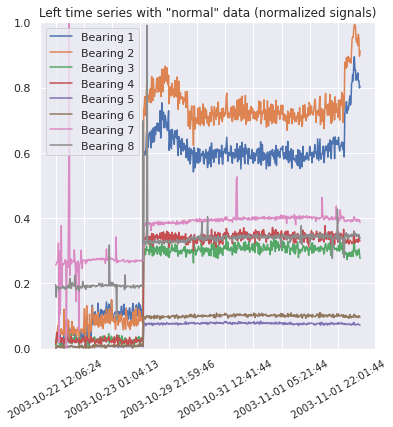

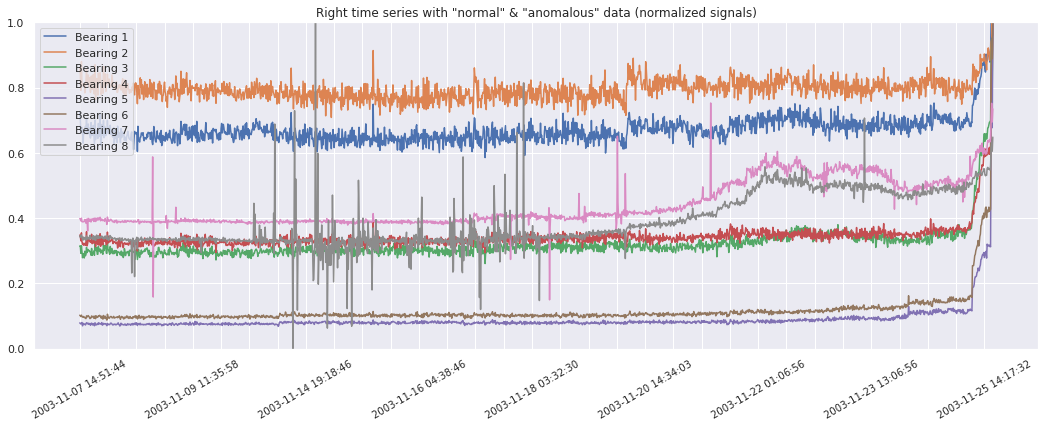

In [9]:
x_ticks_span = 50

X_train.plot(figsize = (6,6), title ='Left time series with "normal" data (normalized signals)')
plt.xticks(np.arange(0, X_train.shape[0], x_ticks_span), fontsize=10, rotation = 30)
plt.ylim(0,1)
plt.legend(loc="upper left")  
plt.show()

X_test.plot(figsize = (18,6), title='Right time series with "normal" & "anomalous" data (normalized signals)')
plt.xticks(np.arange(0, X_test.shape[0], x_ticks_span), fontsize=10, rotation = 30)
plt.ylim(0,1)
plt.legend(loc="upper left")  
plt.show()

## Two components (PCA) just for visualization purposes
Training of the model will use the 4 bearings data, without PCA dimensional reduction.

In fact, the Autoencoder model will have a central (hidden) layer with two nodes (that play the role of the 2 PCA components). Neural Network have the advantage of being able to deal with both linear & non linear models. 

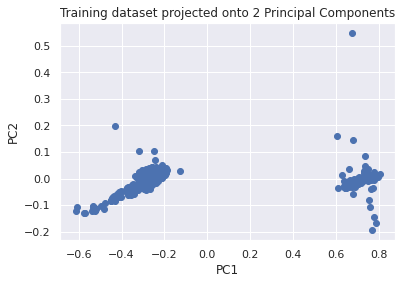

In [10]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
plt.scatter(x_pca['PC1'], x_pca['PC2'])
plt.title('Training dataset projected onto 2 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [11]:
print(pca.explained_variance_ratio_)

[0.97683716 0.0097308 ]


# Build autoencoder model

We don't need to apply dimensional reduction, it's done by the Autoencoder model (central layer of two nodes in the Neural Network are the equivalent to the 2 Principal Components)

In [12]:
seed(10)
tensorflow.random.set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(1,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=20
BATCH_SIZE=10

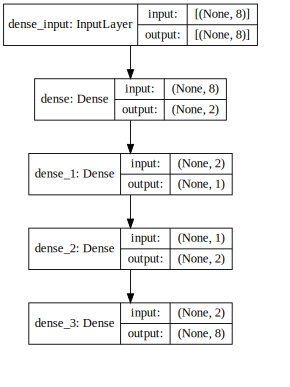

In [13]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model, dpi=80, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

# Fitting the model
To keep track of the accuracy during training, we use 5% of the training data for validation after each epoch (validation_split = 0.05)

In [14]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Epoch 1/20
52/52 [==============================] - 1s 11ms/step - loss: 0.1193 - val_loss: 0.1990
Epoch 2/20
52/52 [==============================] - 0s 1ms/step - loss: 0.0903 - val_loss: 0.1575
Epoch 3/20
52/52 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.1259
Epoch 4/20
52/52 [==============================] - 0s 1ms/step - loss: 0.0526 - val_loss: 0.1001
Epoch 5/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0806
Epoch 6/20
52/52 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0653
Epoch 7/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0531
Epoch 8/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0194 - val_loss: 0.0433
Epoch 9/20
52/52 [==============================] - 0s 1ms/step - loss: 0.0155 - val_loss: 0.0350
Epoch 10/20
52/52 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0285
Epoch 11/20
52/52 

## Evaluate the model: validation vs. training loss

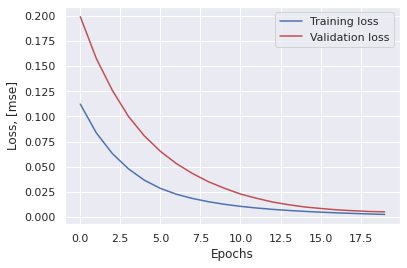

In [15]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
#plt.ylim([0,.1])
plt.show()

# Distribution of loss function in the training set:
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly.

In doing this, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


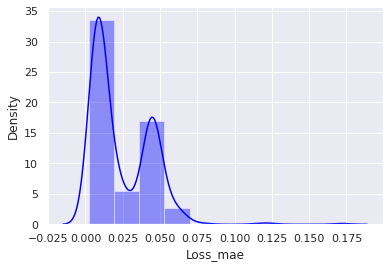

In [16]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
#plt.xlim([0.0,.005])

From the above loss distribution, let us try a threshold of 0.3 for flagging an anomaly.

In [17]:
threshold = 0.075

 We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

In [18]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.tail()

,Loss_mae,Threshold,Anomaly
2003-11-25 16:07:32,0.180793,0.075,True
2003-11-25 23:13:21,0.325078,0.075,True
2003-11-25 23:19:56,0.366962,0.075,True
2003-11-25 23:29:56,0.330224,0.075,True
2003-11-25 23:39:56,0.421493,0.075,True


We then calculate the same metrics also for the training set, and merge all data in a single dataframe:

In [19]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = threshold
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored_train.head()

,Loss_mae,Threshold,Anomaly
2003-10-22 12:06:24,0.052324,0.075,False
2003-10-22 12:09:13,0.050502,0.075,False
2003-10-22 12:14:13,0.050800,0.075,False
2003-10-22 12:19:13,0.049786,0.075,False
2003-10-22 12:24:13,0.043433,0.075,False


In [20]:
scored = pd.concat([scored_train, scored])

An outlier is a point that is distant from others, so the **score** value can be understood *as a distance*. Let's add a column in the training set to flag the anomalies.

# Results from Autoencoder model
Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure:

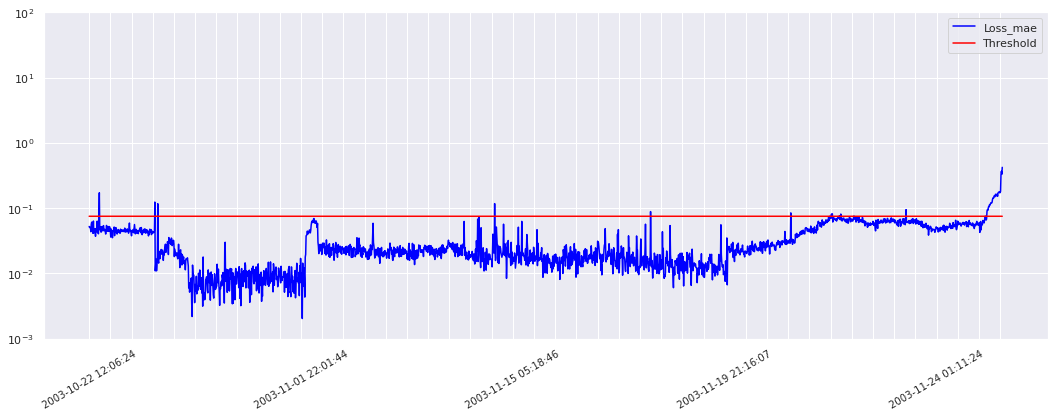

In [21]:
scored.plot(logy=True,  figsize = (18,6), ylim = [1e-3,1e2], color = ['blue','red'])
plt.xticks(np.arange(0, scored.shape[0], 50), fontsize=10, rotation = 30)
plt.show()

# Conclusion
- The Autoencoder model performs as well as the PCA + Mahalanobis distance model